### Imports

In [5]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import numpy as np
import glob2
import h5py
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import ipynb
import importlib

In [6]:
import ipynb.fs.full.modules.Config as config

In [7]:
importlib.reload(config)

<module 'ipynb.fs.full.modules.Config' (/Users/dieumynguyen/Desktop/Projects/bee_communication_v2/ipynb/modules/Config.ipynb)>

### Read Config File

In [71]:
def read_config(base_exp_dir):
    cfg_path = base_exp_dir + "/exp_1.cfg"
    cfg_path, os.path.exists(cfg_path)

    with open(cfg_path, "r") as infile:
        lines = [line.split() for line in infile]
        cfg_opts = {}
        for key, val in lines:
            key = key.replace('--', '')

            try:
                val = float(val)
            except:
                try:
                    val = int(val)
                except:
                    if val.startswith("T"):
                        val = True
                    elif val.startswith("F"):
                        val = False
                    pass
            cfg_opts[key] = val
    return cfg_opts

In [74]:
base_exp_dir = "/Users/dieumynguyen/Desktop/Projects/bee_communication_v2/script/experiments/cfg__exp_1__2019-01-12_21-34-53"
config = read_config(base_exp_dir)

In [75]:
config

{'decay': 18.0,
 'diffusion_coefficient': 0.25,
 'dt': 0.05,
 'dx': 0.01,
 'enable_probabilistic': False,
 'measurements_on': False,
 'num_workers': 70.0,
 'queen_bias_scalar': 0.0,
 'queen_emission_frequency': 20.0,
 'queen_initial_concentration': 0.15,
 'queen_x': 0.0,
 'queen_y': 0.0,
 'random_seed': 80.0,
 'save_folder': 'experiments',
 'space_constraint': 0.85,
 't_max': 1.0,
 't_min': 0.0,
 't_threshold': 100.0,
 'verbose': True,
 'worker_bias_scalar': 5.0,
 'worker_initial_concentration': 0.15,
 'worker_step_size': 0.05,
 'worker_threshold': 0.01,
 'worker_trans_prob': 1.0,
 'worker_wait_period': 20.0,
 'x_max': 3.0,
 'x_min': -3.0}

### Data visualization

- Read in envir_hist.h5 and bee_hist.h5 <br>
- Make movies <br>
- Plot distance from queen 

In [14]:
glob2.glob("*.h5")

['bee_hist.h5', 'envir_hist.h5']

In [17]:
env_path = "envir_hist.h5"
bee_path = "bee_hist.h5"
os.path.exists(env_path), os.path.exists(bee_path)

(True, True)

In [18]:
with h5py.File(env_path, 'r') as infile:
    cmaps = np.array(infile['concentration'])

In [19]:
bee_data = {}
with h5py.File(bee_path, 'r') as infile:
    for key, val in infile.items():
        bee_data[key] = np.array(val)

In [20]:
bee_data.keys()

dict_keys(['bee_i', 'distance_from_queen', 'gradient_x', 'gradient_y', 'state', 't', 'wx', 'wy', 'x', 'y'])

In [21]:
bee_nums = np.unique(bee_data['bee_i'])
bees = {}
for bee_num in bee_nums:
    idxs = np.where(bee_data['bee_i']==bee_num)
    bee_x = bee_data['x'][idxs]
    bee_y = bee_data['y'][idxs]
    bee_state = bee_data['state'][idxs]
    distance = bee_data['distance_from_queen'][idxs]
    bee_grads = bee_data['gradient_x'][idxs], bee_data['gradient_y'][idxs]
    bias = bee_data['wx'][idxs], bee_data['wy'][idxs]
    bees[bee_num] = {"x" : bee_x, "y" : bee_y, "state": bee_state,
                    "distance": distance, "grads" : bee_grads}

In [22]:
bees.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69])

### Get params from config

In [79]:
X_MIN = config["x_min"]
X_MAX = config["x_max"]
DX = config["dx"]
GRID_SIZE = np.arange(X_MIN, X_MAX+DX, DX).shape[0]

In [80]:
convert_xy_to_index = lambda xy: ((xy - X_MIN) / (X_MAX - X_MIN)) * GRID_SIZE

In [81]:
convert_xy_to_index(0)

300.5

In [83]:
D = config["diffusion_coefficient"]
DECAY = config["decay"]

In [84]:
T_MIN = config["t_min"]
T_MAX = config["t_max"]
DT = config["dt"]
NUM_TIMESTEPS = np.arange(T_MIN, T_MAX+DT, DT).shape[0]
NUM_TIMESTEPS

21

In [85]:
QUEEN_BEE_A = config["queen_initial_concentration"]
WORKER_BEE_A = config["worker_initial_concentration"]
THRESHOLD = config["worker_threshold"]
WB = config["worker_bias_scalar"]

### Make Frames

In [86]:
colors = ["red", "gray", "#479030", "orange"]
color_decoder = {
    0: colors[1],
    1: colors[2],
    2: colors[2],
    3: colors[3]
}

In [88]:
for frame_i in range(0, cmaps.shape[0], 5):
    # CONCENTRATION
    cmap = cmaps[frame_i]
    plt.imshow(cmap, cmap='viridis', vmin=None, vmax=None)
    plt.colorbar(shrink=0.8, format='%.2e')  
    
    # QUEEN
    queen = convert_xy_to_index(0)
    plt.scatter(queen, queen, c="red", s=100, edgecolors='black', marker='o')     
    
    # WORKERS
    for bee_key, bee_vals in bees.items():
        x = bee_vals['x'][frame_i]
        y = bee_vals['y'][frame_i]
        state = bee_vals['state'][frame_i]
        color = color_decoder[state]
        plt.scatter(convert_xy_to_index(x), convert_xy_to_index(y), 
                    color=color, s=30, edgecolors='black')
        
    # FORMATTING
    texts = ["Queen", "Worker - random walk", "Worker - scenting", "Worker - directed walk"]
    patches = [ plt.plot([],[], marker="o", ms=5, ls="", mec=None, color=colors[i], 
                 markeredgecolor="black", label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
    plt.legend(handles=patches, bbox_to_anchor=(0.5, -0.22), 
               loc='center', ncol=2, numpoints=1, labelspacing=0.3,
               fontsize='small', fancybox="True",
               handletextpad=0, columnspacing=0)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(0, 600)
    plt.ylim(600, 0) 

    plt.title(f"Q{QUEEN_BEE_A}_W{WORKER_BEE_A}_D{D}_T{THRESHOLD}_wb{WB}_decay{DECAY} \n t: {frame_i+1}/{NUM_TIMESTEPS}")

    # SAVING FRAMES
    file_path = f't{frame_i+1:03d}.png'
    filename = f'{config["save_folder"]}/{file_path}'
    plt.savefig(filename, bbox_inches='tight', dpi=200)
    plt.close()


### Plot average worker distance from queen

In [89]:
num_bees = np.unique(bee_data['bee_i']).shape[0]
num_bees

70

In [90]:
distances_per_t = bee_data['distance_from_queen'].reshape(-1, num_bees)
median_distances = np.median(distances_per_t, axis=1)

Text(0,0.5,'Median worker distance from queen')

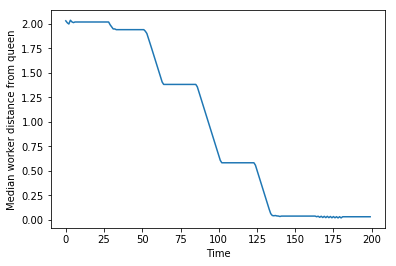

In [91]:
plt.plot(median_distances)
plt.xlabel('Time')
plt.ylabel('Median worker distance from queen')

## Video Stuff

In [111]:
!convert -delay 25 $config["save_folder"]/t*.png $config.VID_PATH

In [ ]:
VLC = "/Applications/VLC.app/Contents/MacOS/VLC"
!$VLC $config.VID_PATH